In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from env import get_db_url
import acquire
import prepare
import warnings
warnings.filterwarnings("ignore")


# Explore data (on train only)

In [2]:
# brings in acquire.py
df = acquire.get_zillow_data()

In [3]:
# runs prepare functions
df = prepare.prep_zillow(df)

In [4]:
df.head()

,bedrooms,bathrooms,square_feet,lot_size,pool,zip_code,year_built,latitude,longitude,fips,assessed_value,tax_value,transaction_date,log_error,transaction_month,county,tax_rate
5,3,2.0,1222,5500,1,96193,1951,33889894.0,-118100732.0,6037,290492,3870,2017-01-03,-0.316484,01,Los Angeles,1.332223
38,4,2.5,1620,8531,1,97099,1967,34440918.0,-119293909.0,6111,369463,4585,2017-01-03,0.102849,01,Ventura,1.240990
40,4,4.0,2840,60548,1,97099,1966,34452715.0,-119266845.0,6111,610795,6970,2017-01-03,-0.069136,01,Ventura,1.141136
54,3,2.0,1638,197651,1,97099,1989,34454777.0,-119197226.0,6111,653582,6997,2017-01-03,-0.010887,01,Ventura,1.070562
58,3,2.0,1583,8000,1,97099,1961,34419017.0,-119296402.0,6111,465462,5644,2017-01-03,0.052558,01,Ventura,1.212559


In [5]:
df.shape

(7850, 17)

In [6]:
# splits my data
train_validate, test = train_test_split(df, test_size = 0.10, random_state = 123)
train, validate = train_test_split(train_validate, test_size = 0.20, random_state = 123)
print(train.shape, validate.shape, test.shape)

(5652, 17) (1413, 17) (785, 17)


In [7]:
train.shape

(5652, 17)

In [8]:
# list discrete columns
discrete = [col for col in [col for col in train.columns if train[col].dtypes in ['int64','float64']] if 'sqft' not in col and  'cnt' not in col and  'nbr' not in col and 'number' not in col and len(train[col].unique())< 50  ]
print('we have {} columns of discrete variables which are columns with unique values less than 50'.format(len(discrete)))

we have 4 columns of discrete variables which are columns with unique values less than 50


In [9]:
# list continuous columns
continuous = [col for col in [col for col in train.columns if train[col].dtypes in ['int64','float64']] if col not in discrete]
print('we have {} columns of continuous variable which are columns with unique values more than 50'.format(len(continuous)))

we have 10 columns of continuous variable which are columns with unique values more than 50


In [10]:
#function to plot parameter values in graph
def univariate(data,col,vartype=[0,1],hue =None):    
    '''
    Univariate function will plot parameter values in graphs.
    df      : dataframe name
    col     : Column name
    vartype : variable type : continuous or categorical
                Continuous(0)   : Distribution, Violin & Boxplot will be plotted.
                Categorical(1) : Countplot will be plotted.
    hue     : Only applicable in categorical analysis.
    '''
    sns.set(style="darkgrid")
    df = data.copy()
    if vartype == 0:
        fig, ax=plt.subplots(nrows =1,ncols=5,figsize=(20,6))
        #
        ax[0].set_title(col+" Distribution Plot")
        sns.distplot(df[col],ax=ax[0])

        ax[1].set_title(col+" Violin Plot")
        sns.violinplot(data =df, x=col,ax=ax[1], inner="quartile")#.set(ylabel='')
        #
        ax[2].set_title(col+" Box Plot")
        sns.boxplot(data =df, x=col,ax=ax[2],orient='v')
        #
        ax[3].set_title(col+" strip Plot")
        sns.stripplot(data =df, x=col,ax=ax[3])
        df[col]=np.log(df[col])
        ax[4].set_title(col+" scatter Plot")
        sns.scatterplot(x =df[col], y=df['logerror'],ax=ax[4])

        

    if vartype == 1:
        temp = pd.Series(data = hue)
        fig, ax = plt.subplots()
      
        width = len(df[col].unique()) + 3 + 2*len(temp.unique())
        fig.set_size_inches(width , 4)
        ax = sns.countplot(data = df, x= col, order=df[col].value_counts().index,hue = hue) 
        if len(temp.unique()) > 0:
            for p in ax.patches:
                ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float(len(df))), (p.get_x()+0.05, p.get_height()+10))  
        else:
            for p in ax.patches:
                ax.annotate(p.get_height(), (p.get_x()+0.16, p.get_height()+10)) 
        del temp
    else:
        exit
    fig.tight_layout()
    plt.show()

In [11]:
#for col in train[continuous].columns:
  #univariate(train,col,0,hue =None)

In [12]:
discrete = [ col for col in discrete if train[col].nunique()>1]

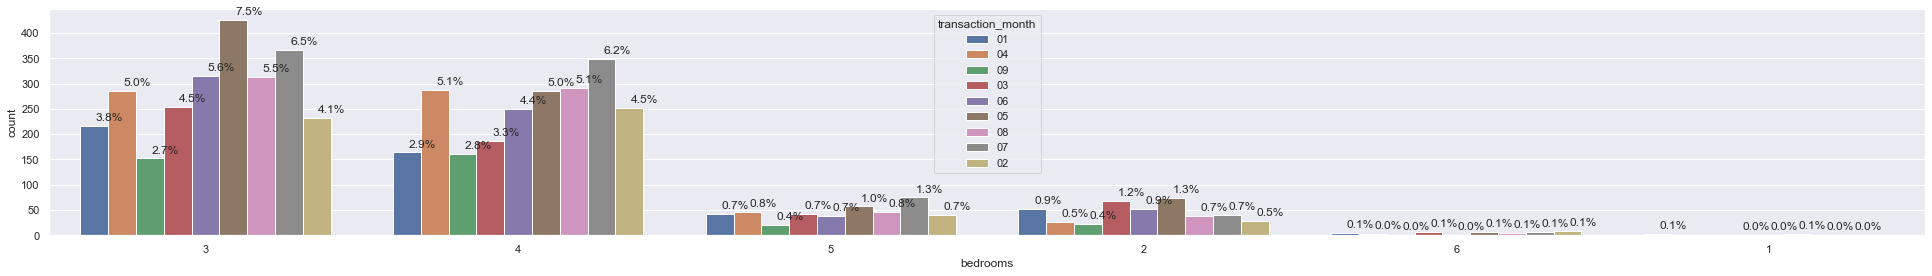

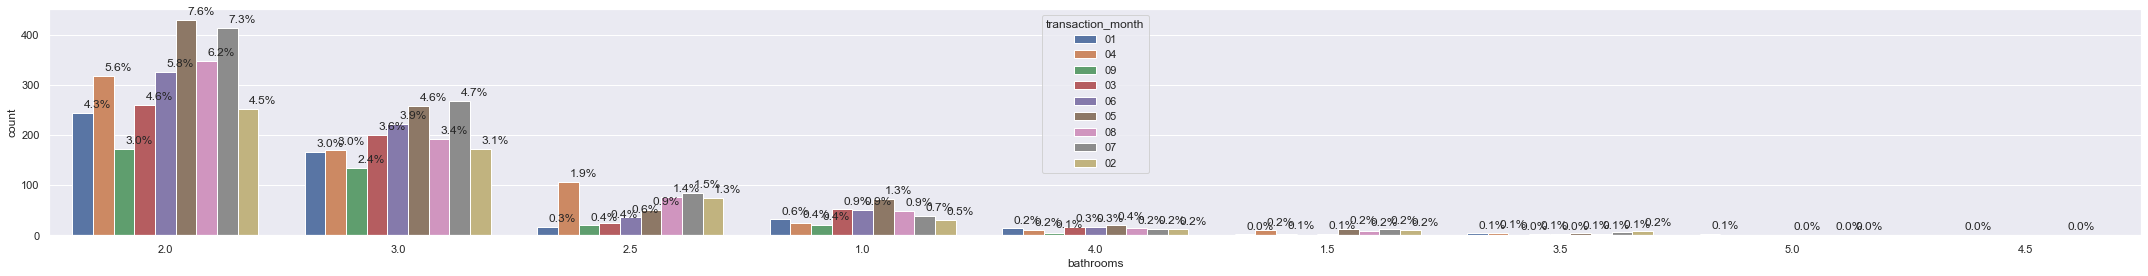

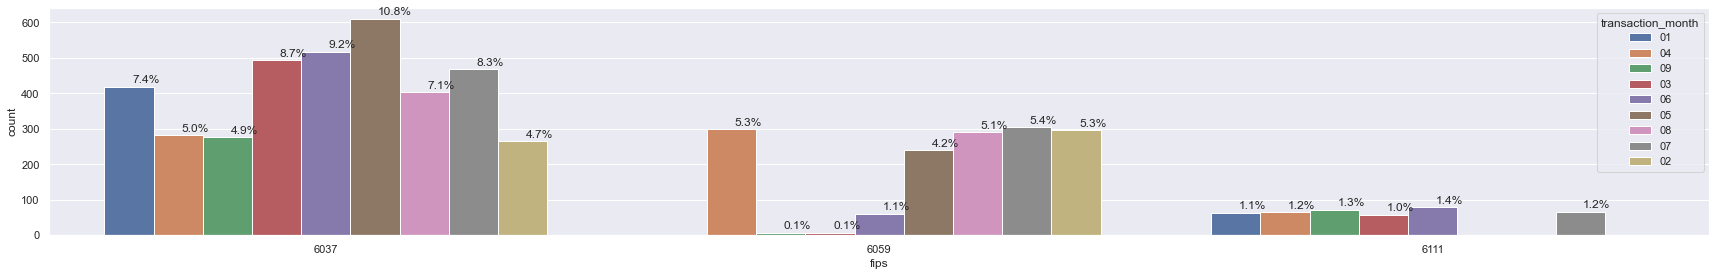

In [13]:
for col in train[discrete].columns:
  univariate(train,col,1,hue =train.transaction_month)

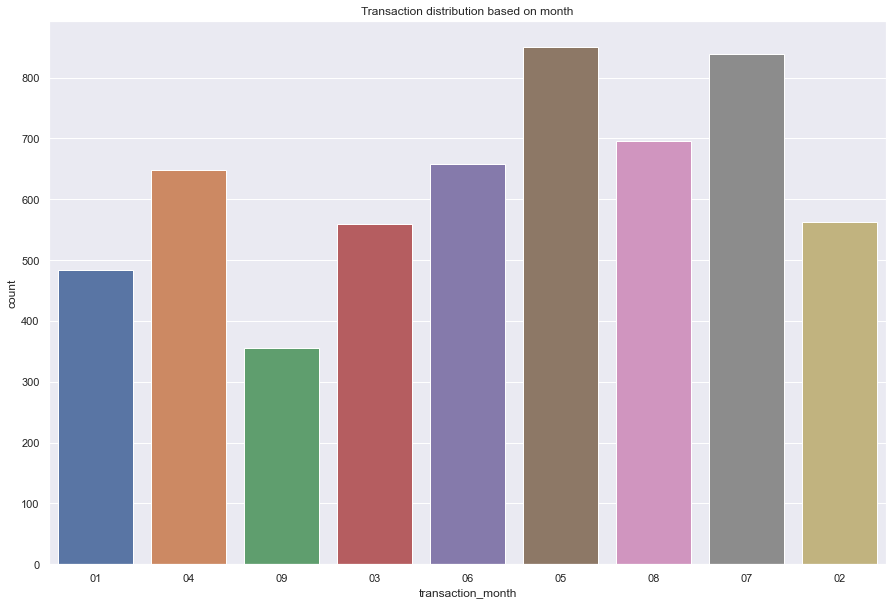

In [14]:
#Temporal data distribution
plt.figure(figsize=(15,10))
sns.countplot(x=train.transaction_month).set_title("Transaction distribution based on month");

## May has the highest amount of transactions

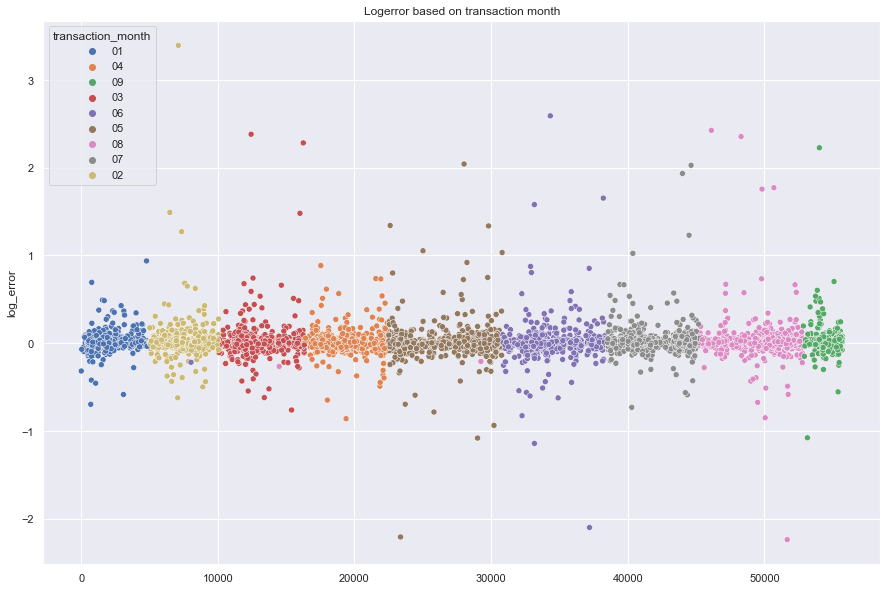

In [15]:
plt.figure(figsize=(15,10))
sns.scatterplot(x=train.index,y=train.log_error,hue=train.transaction_month).set_title("Logerror based on transaction month");

In [16]:
# list my categorical columns
categorical = [col for col in train.columns if train[col].dtypes  in ['object'] ]
categorical

['transaction_date', 'transaction_month', 'county']

In [17]:
# lists the columns I am using
train.columns

Index(['bedrooms', 'bathrooms', 'square_feet', 'lot_size', 'pool', 'zip_code',
       'year_built', 'latitude', 'longitude', 'fips', 'assessed_value',
       'tax_value', 'transaction_date', 'log_error', 'transaction_month',
       'county', 'tax_rate'],
      dtype='object')

In [18]:
train.head()

,bedrooms,bathrooms,square_feet,lot_size,pool,zip_code,year_built,latitude,longitude,fips,assessed_value,tax_value,transaction_date,log_error,transaction_month,county,tax_rate
4192,4,4.0,2217,7570,1,96321,1955,34173179.0,-118263594.0,6037,875694,9552,2017-01-27,0.004939,01,Los Angeles,1.090792
20164,4,2.5,2635,5100,1,96954,1979,33714869.0,-117765543.0,6059,390727,4101,2017-04-17,-0.003324,04,Orange,1.049582
53874,4,3.0,2826,7590,1,97097,1986,34263913.0,-118870032.0,6111,508519,5686,2017-09-08,-0.005168,09,Ventura,1.118149
16009,3,1.0,1215,5100,1,96213,1952,33839059.0,-118100188.0,6037,434917,5366,2017-03-31,1.480816,03,Los Angeles,1.233799
1816,3,2.0,1822,7552,1,96369,1954,34237232.0,-118500880.0,6037,499307,6038,2017-01-12,-0.012431,01,Los Angeles,1.209276


for i, predictor in enumerate(train.drop(columns=['transaction_date','zip_code','latitude','longitude','fips'])):
    plt.figure(i)
    sns.countplot(data=train, x=predictor, hue='transaction_month')

In [19]:
categorical = [col for col in train.columns if train[col].dtypes  in ['object'] ]
categorical

['transaction_date', 'transaction_month', 'county']

### Identifying relationships between tax_value and other features

<AxesSubplot:xlabel='transaction_month', ylabel='tax_value'>

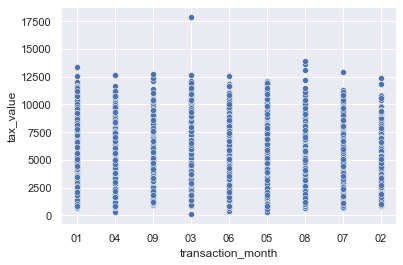

In [20]:
sns.scatterplot(x=train.transaction_month, y=train.tax_value)

In [21]:
#counts the number of transactions in each month
train.transaction_month.value_counts()

05    851
07    839
08    695
06    658
04    648
02    563
03    559
01    483
09    356
Name: transaction_month, dtype: int64

### May is the highest month for transactions

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

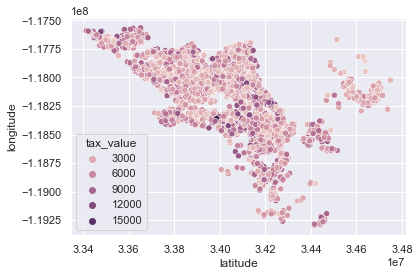

In [22]:
sns.scatterplot(x=train.latitude , y=train.longitude, hue=train.tax_value)

<AxesSubplot:xlabel='tax_rate', ylabel='square_feet'>

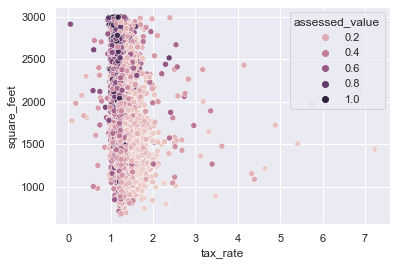

In [23]:
sns.scatterplot(x=train.tax_rate , y=train.square_feet, hue=train.assessed_value)

### the higher the square_feet, the higher the assessed_value

<AxesSubplot:xlabel='tax_value', ylabel='bedrooms'>

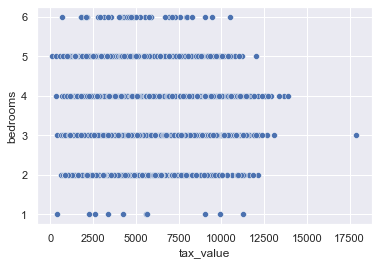

In [24]:
sns.scatterplot(x=train.tax_value , y=train.bedrooms)

### 3 and 4 bedrooms have the highest tax_value as represented

In [25]:
train.bedrooms.value_counts()

3    2562
4    2226
5     408
2     406
6      40
1      10
Name: bedrooms, dtype: int64

<AxesSubplot:xlabel='assessed_value', ylabel='tax_value'>

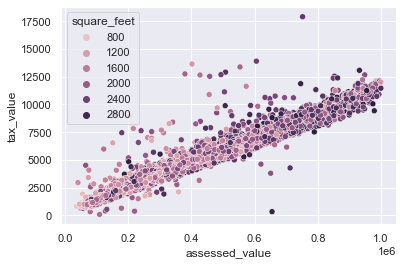

In [26]:
sns.scatterplot(x=train.assessed_value, y=train.tax_value, hue=train.square_feet)

### the higher the square_feet the higher the tax_value and assessed value

<AxesSubplot:xlabel='county', ylabel='assessed_value'>

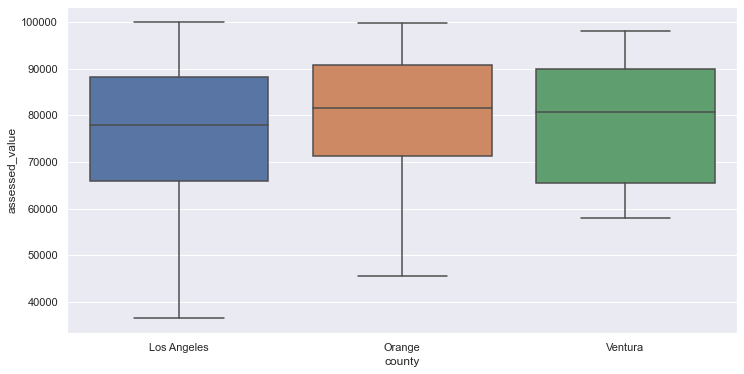

In [27]:
plt.figure(figsize=(12,6))
sns.boxplot(x= train[train.assessed_value<1000000].county, y= train[train.assessed_value<100000].assessed_value, data=train[train.assessed_value<100000])

### Highest assessed values are in Orange county

<AxesSubplot:xlabel='assessed_value', ylabel='Density'>

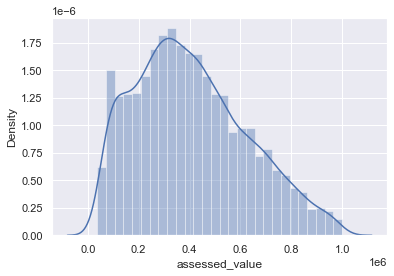

In [28]:
# plot showing distribution of assessed_values
sns.distplot(train.assessed_value)

In [29]:
#create a subset of df with continuous variables to create pairplot
train_corr = train[['bathrooms', 'bedrooms', 'square_feet', 'lot_size', 'assessed_value']]

In [30]:
# using corr() function to find correlation between columns
train_corr = train_corr.corr()
train_corr

,bathrooms,bedrooms,square_feet,lot_size,assessed_value
bathrooms,1.000000,0.474357,0.707201,0.082465,0.270707
bedrooms,0.474357,1.000000,0.508887,-0.018564,0.108301
square_feet,0.707201,0.508887,1.000000,0.128391,0.374145
lot_size,0.082465,-0.018564,0.128391,1.000000,0.051627
assessed_value,0.270707,0.108301,0.374145,0.051627,1.000000


<AxesSubplot:>

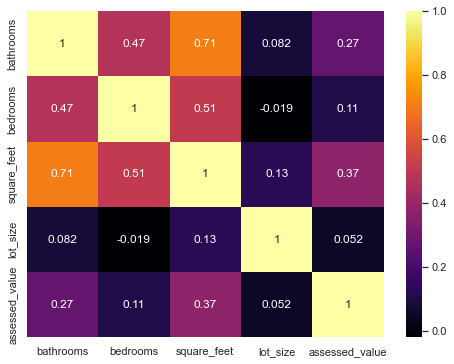

In [31]:
# plots heatmap and correlation values 
plt.figure(figsize=(8,6))
sns.heatmap(train_corr, annot=True, cmap='inferno')

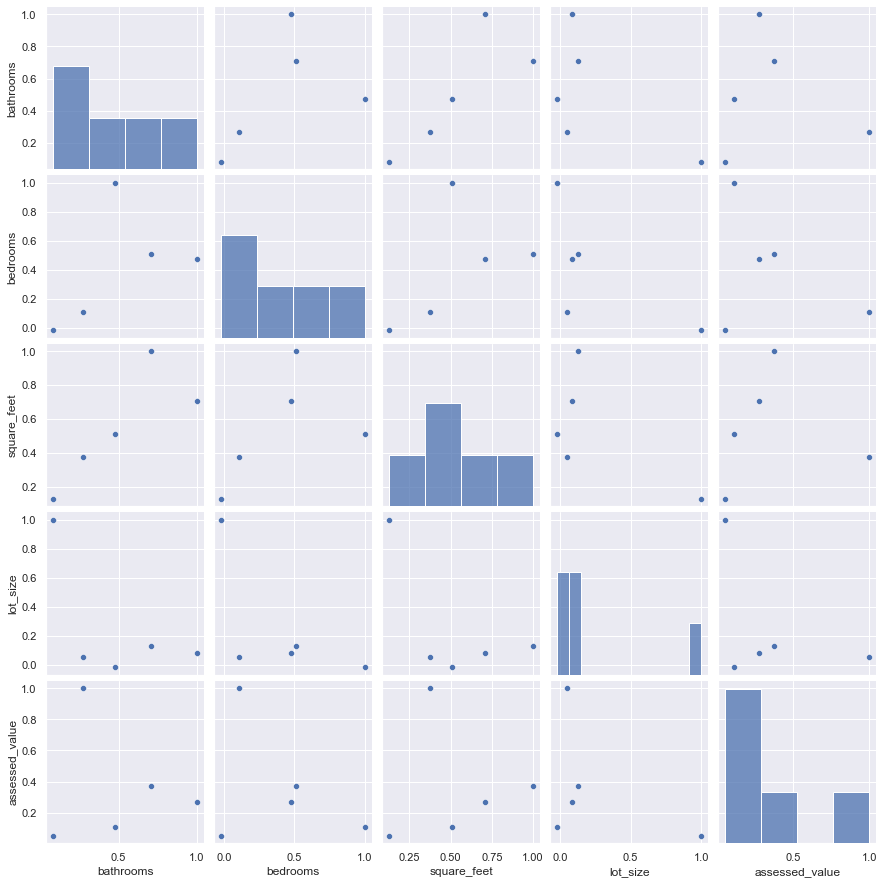

In [32]:
sns.pairplot(train_corr)

### $H_0$: there is no relationship between assessed values and number of bedrooms, bathrooms and square_feet
### $H_a$: There is a relationship between assessed values and number of bedrooms, bathrooms and square_feet

In [48]:
#Lets take a look at simple model based on bathoom, bedroom and squarefeet and compare if against the baseline(median home value)
X_train = train[['bedrooms', 'bathrooms', 'square_feet']]
y_train = train[['assessed_value']]
y_train['y_baseline'] = train['assessed_value'].median()

In [49]:
y_train.head()

,assessed_value,y_baseline
4192,875694,380351.5
20164,390727,380351.5
53874,508519,380351.5
16009,434917,380351.5
1816,499307,380351.5


In [51]:
# Calculating the baseline (based on median) RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_baseline = sqrt(mean_squared_error(y_train.assessed_value, y_train.y_baseline))

rmse_baseline

219730.81030193748

In [52]:
#We now create a OLS model based on bedrooms, bathrooms and square_feet
from statsmodels.formula.api import ols

# generate parameters, i.e. create model
ols_model = ols('assessed_value ~ bedrooms + bathrooms + square_feet', data = train).fit()

# compute predictions and add to original dataframe
y_train['yhat'] = ols_model.predict(X_train)

In [53]:
 y_train.head()

,assessed_value,y_baseline,yhat
4192,875694,380351.5,462715.794623
20164,390727,380351.5,514631.783768
53874,508519,380351.5,554272.688304
16009,434917,380351.5,282844.559319
1816,499307,380351.5,400914.166695


In [54]:
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         assessed_value   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     331.7
Date:                Wed, 08 Jun 2022   Prob (F-statistic):          2.07e-198
Time:                        00:30:11   Log-Likelihood:                -77041.
No. Observations:                5652   AIC:                         1.541e+05
Df Residuals:                    5648   BIC:                         1.541e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.594e+05   1.34e+04     11.864      0.000    1.33e+05    1.86e+05
bedrooms    -3.315e+04   4118.372     -8.049      0.000   -4.12e+04   -2.51e+04
bathrooms    1.343e+04   6087.582      2.206      0.027    1494.749    2.54e+04
square_feet   172.3902      7.672     22.471      0.000     157.351     187.430
==============================================================================
Omnibus:                      123.298   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              108.485
Skew:                           0.283   Prob(JB):                     2.77e-24
Kurtosis:                       2.624   Cond. No.                     1.02e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### My p-values are <0.05, I can reject my null hypothesis.
### This means that there is statistically significant relationship between assessed_values and the independent variables I used.

In [55]:
rmse = sqrt(mean_squared_error(y_train.assessed_value, y_train.yhat))
rmse

201147.69679039976

###  RMSE for OLS model with bedrooom, bathroom and square feet 201147 < the baseline 219730.  R2 is 0.15 and p-value is 0.

In [35]:
# scale data from function in prepare.py
train_scaled, validate_scaled, test_scaled = prepare.scale_data(train, validate, test)

In [36]:
train_scaled

,tax_value,assessed_value,bathrooms,bedrooms,square_feet,lot_size
4192,1.835125,2.150082,2.612581,0.671184,0.575266,-0.197337
20164,-0.343246,-0.072995,0.243528,0.671184,1.388808,-0.372952
53874,0.290164,0.466960,1.033212,0.671184,1.760546,-0.195915
16009,0.162283,0.129571,-2.125525,-0.629753,-1.374900,-0.372952
1816,0.430833,0.424733,-0.546156,-0.629753,-0.193512,-0.198617
...,...,...,...,...,...,...
33111,0.043194,0.057103,-0.546156,-0.629753,-0.631423,-0.237793
54678,1.826333,1.709218,-0.546156,-0.629753,1.157202,0.557947
55262,-0.641368,-0.631750,-0.546156,-0.629753,-1.298995,-0.163423
14443,-1.259992,-1.271897,-0.546156,-0.629753,-0.207136,0.341379
